In [15]:
import numpy as np 
import pandas as pd 
import os
import torch
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import cv2
from torchvision.models import *

from PIL import Image

import json
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pickle

In [16]:
train_directory = 'data/training/'
valid_directory = 'data/validation/'
test_directory  = 'data/files_for_testing/'

In [5]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 7, figsize=(30, 30))  
    axes = axes.flatten() 
    for img, label, ax in zip(images_arr, labels, axes): 
        ax.imshow(img)  
        ax.set_title(label)
        ax.axis('off') 
    plt.tight_layout()  
    plt.show()  

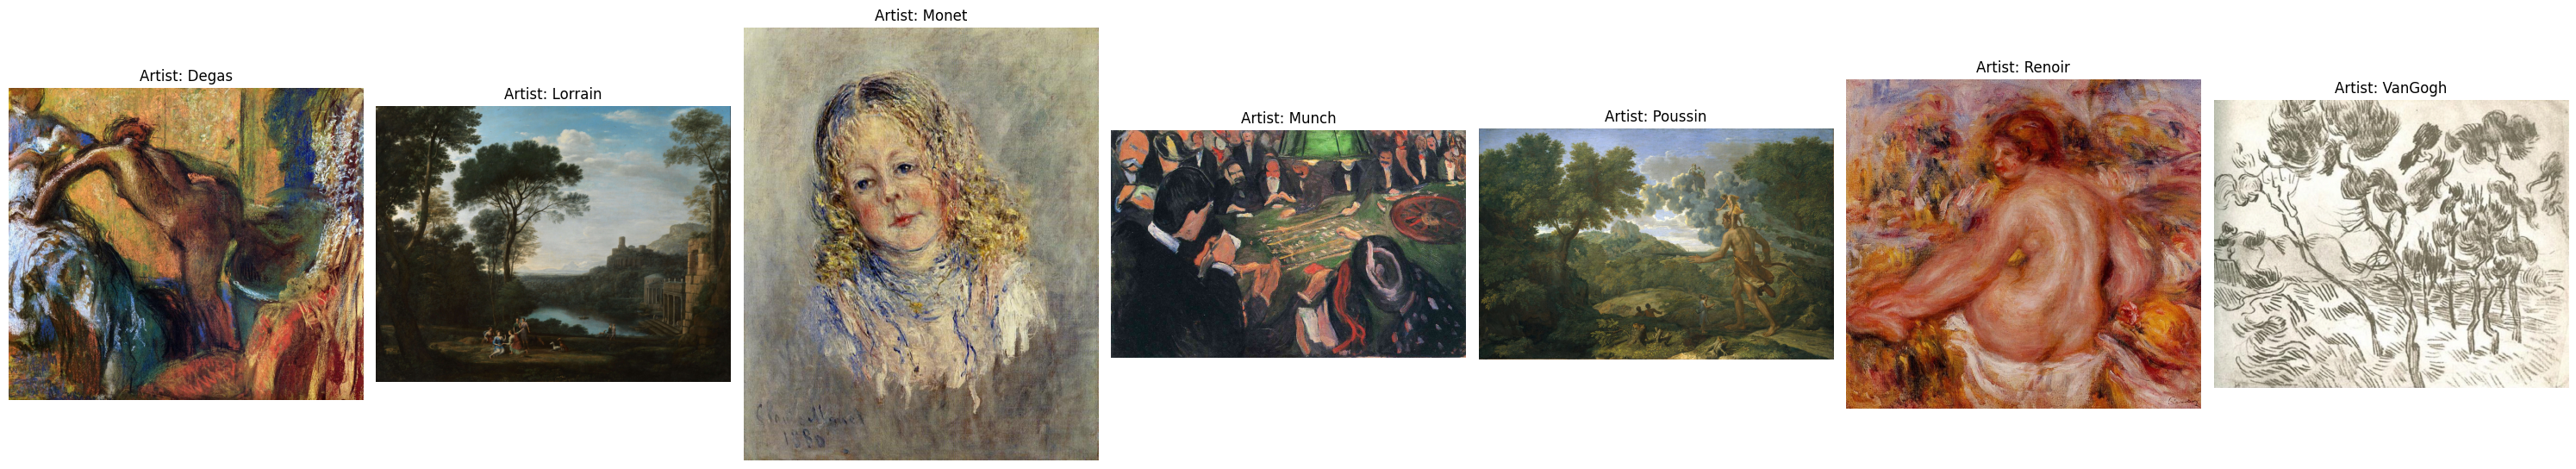

In [11]:
images_arr = []
labels = []

painters = [d for d in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, d))]
for painter in painters:
    tr_directory = os.path.join(train_directory, painter)
    image_files = [filename for filename in os.listdir(tr_directory) if filename.endswith('.jpg')]
    if image_files: 
        img = Image.open(os.path.join(tr_directory, image_files[12]))
        images_arr.append(img)
        labels.append("Artist: " + painter)

plotImages(images_arr, labels)

In [11]:
# image_transforms = { 
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=30),
#         transforms.RandomHorizontalFlip(),
#         transforms.Resize((256, 256)),
#         #transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'valid': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.Resize((256, 256)),
#         #transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])
# }

In [17]:
dataset = {
    'train': datasets.ImageFolder(root=train_directory),# transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory),# transform=image_transforms['valid']),
    'test' : datasets.ImageFolder(root=test_directory)
}
 
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

In [18]:
class_names = dataset['train'].classes
print("Classes:", class_names)

Classes: ['Degas', 'Lorrain', 'Monet', 'Munch', 'Poussin', 'Renoir', 'VanGogh']


In [19]:
class_counts = {}

for class_name in class_names:
    count = 0 

    for _, label in dataset['train']:
        if class_names[label] == class_name:
            count += 1

    class_counts[class_name] = count

for class_name, count in class_counts.items():
    print(f"Liczba elementów w klasie {class_name}: {count}")


Liczba elementów w klasie Degas: 469
Liczba elementów w klasie Lorrain: 77
Liczba elementów w klasie Monet: 1025
Liczba elementów w klasie Munch: 146
Liczba elementów w klasie Poussin: 129
Liczba elementów w klasie Renoir: 1059
Liczba elementów w klasie VanGogh: 1447


In [20]:
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

print(class_counts_df)


     Class  Count
0    Degas    469
1  Lorrain     77
2    Monet   1025
3    Munch    146
4  Poussin    129
5   Renoir   1059
6  VanGogh   1447


In [21]:
class_counts_df['Class Weight'] = class_counts_df['Count'].sum() / (class_counts_df['Count'] * class_counts_df.shape[0])

print(class_counts_df)


     Class  Count  Class Weight
0    Degas    469      1.325617
1  Lorrain     77      8.074212
2    Monet   1025      0.606551
3    Munch    146      4.258317
4  Poussin    129      4.819491
5   Renoir   1059      0.587077
6  VanGogh   1447      0.429657


In [22]:
class_weights = class_counts_df['Class Weight'].to_dict()
class_weights

{0: 1.325616813889735,
 1: 8.074211502782932,
 2: 0.6065505226480836,
 3: 4.258317025440313,
 4: 4.819490586932448,
 5: 0.5870767570484284,
 6: 0.42965741929114426}

In [23]:
name = class_counts_df['Class'].values

In [24]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = class_counts_df.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=train_directory,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=valid_directory,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=name.tolist()
                                                   )


STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3485 images belonging to 7 classes.


Found 229 images belonging to 7 classes.
Total number of batches = 217 and 14


In [25]:
test_generator = train_datagen.flow_from_directory(directory=test_directory,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    classes=name.tolist()
                                                   )

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 295 images belonging to 7 classes.


In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [16]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [17]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [18]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

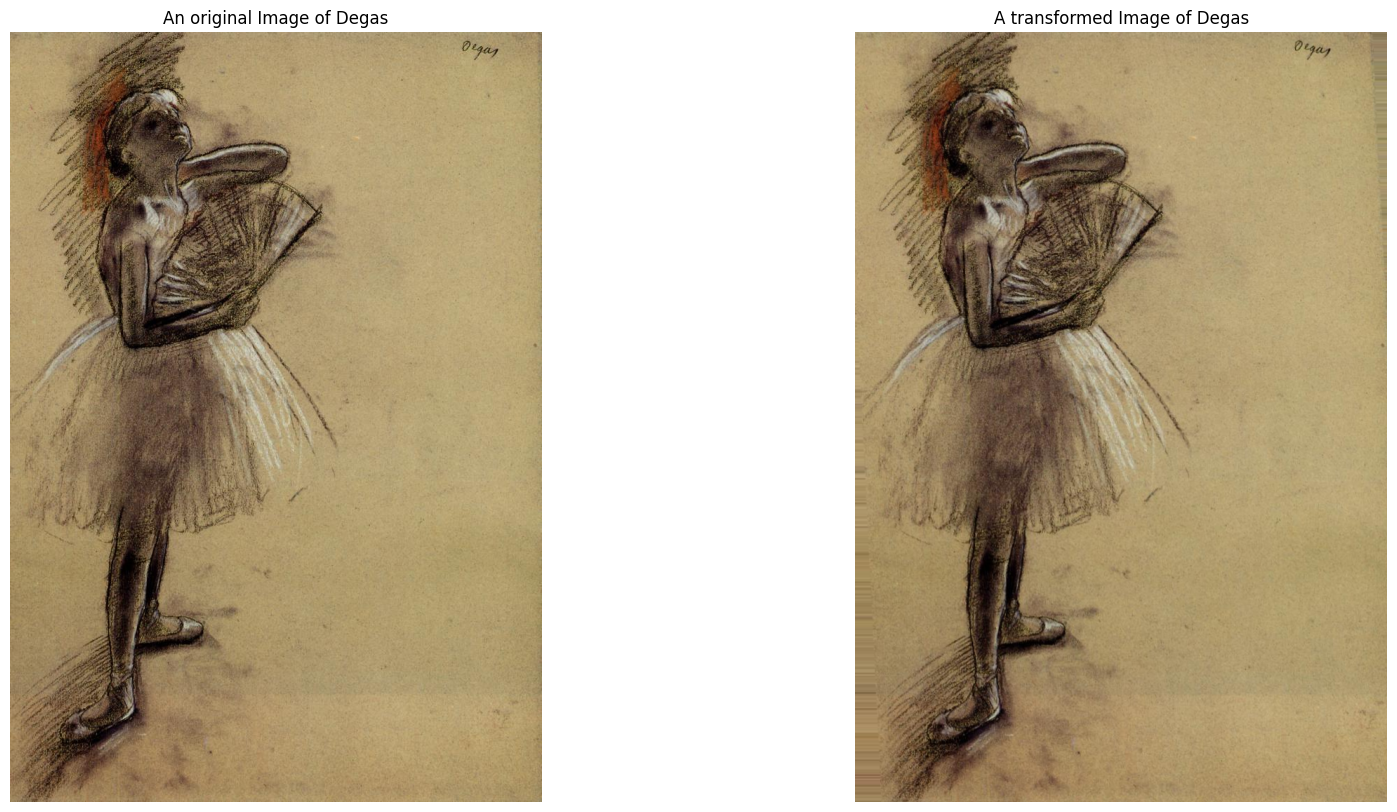

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(name)
random_image = random.choice(os.listdir(os.path.join(train_directory, random_artist)))
random_image_file = os.path.join(train_directory, random_artist, random_image)

image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()


In [20]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              workers=16,
                              use_multiprocessing=False,
                              class_weight=class_weights
                             )

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16620\2893128123.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/10
217/217 [==============================] - 977s 4s/step - loss: 1.1480 - accuracy: 0.5615 - val_loss: 6.2330 - val_accuracy: 0.1161 - lr: 1.0000e-04
Epoch 2/10
217/217 [==============================] - 894s 4s/step - loss: 0.7591 - accuracy: 0.7334 - val_loss: 2.2794 - val_accuracy: 0.0312 - lr: 1.0000e-04
Epoch 3/10
217/217 [==============================] - 892s 4s/step - loss: 0.6494 - accuracy: 0.7973 - val_loss: 2.3588 - val_accuracy: 0.0848 - lr: 1.0000e-04
Epoch 4/10
217/217 [==============================] - 875s 4s/step - loss: 0.5577 - accuracy: 0.8331 - val_loss: 1.3638 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 5/10
217/217 [==============================] - 817s 4s/step - loss: 0.4996 - accuracy: 0.8677 - val_loss: 0.8932 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 6/10
217/217 [==============================] - 940s 4s/step - loss: 0.4497 - accuracy: 0.8772 - val_loss: 0.7982 - val_accuracy: 0.7991 - lr: 1.0000e-04
Epoch 7/10
217/217 [====================

In [21]:
PATH="history1.pth" 
print("\nSaving the model...")
torch.save(history1, PATH)


Saving the model...


In [22]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weights
                             ) 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16620\334847092.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
217/217 [==============================] - 610s 3s/step - loss: 0.1695 - accuracy: 0.9700 - val_loss: 0.4710 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 2/50
217/217 [==============================] - 618s 3s/step - loss: 0.1452 - accuracy: 0.9694 - val_loss: 0.4339 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 3/50
217/217 [==============================] - 625s 3s/step - loss: 0.1292 - accuracy: 0.9717 - val_loss: 0.3831 - val_accuracy: 0.9196 - lr: 1.0000e-04
Epoch 4/50
217/217 [==============================] - 587s 3s/step - loss: 0.1223 - accuracy: 0.9752 - val_loss: 0.3700 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 5/50
217/217 [==============================] - 568s 3s/step - loss: 0.1179 - accuracy: 0.9749 - val_loss: 0.3878 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 6/50
217/217 [==============================] - 562s 3s/step - loss: 0.1064 - accuracy: 0.9801 - val_loss: 0.3954 - val_accuracy: 0.9107 - lr: 1.0000e-04
Epoch 7/50
217/217 [====================

In [23]:
# Save the model
PATH="history2.pth" 
print("\nSaving the model...")
torch.save(history2, PATH)


Saving the model...


In [24]:
# Save the model
PATH="model_RESNET50.pkl" 
print("\nSaving the model...")
torch.save(model, PATH)


Saving the model...


In [25]:
history1 = torch.load("history1.pth")
history2 = torch.load("history2.pth")

In [26]:
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

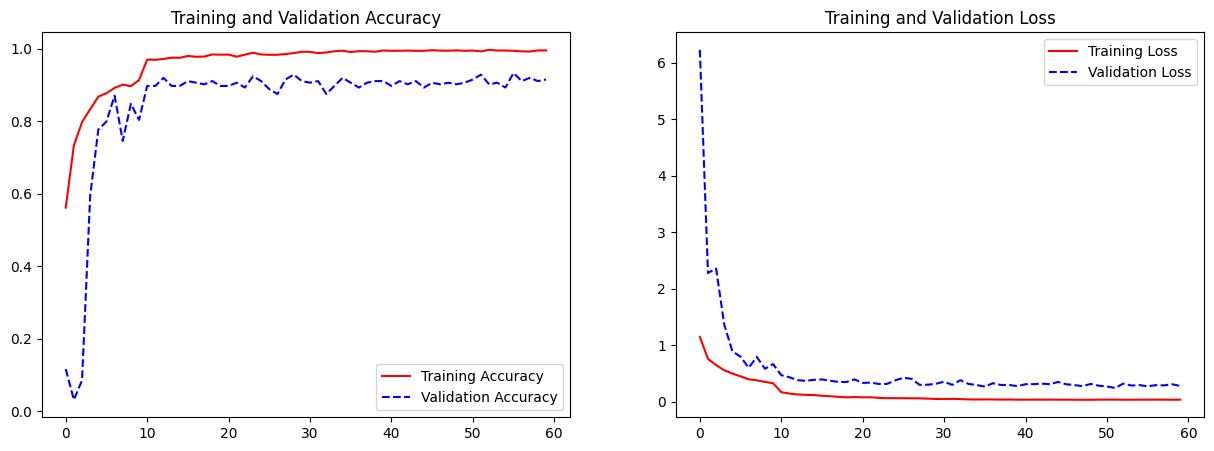

In [27]:
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [28]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16620\4076090939.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator, verbose=1)


218/218 [==============================] - 576s 3s/step - loss: 0.0447 - accuracy: 0.9977
Prediction accuracy on train data = 0.9977044463157654


In [29]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16620\2117339602.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(valid_generator, verbose=1)


15/15 [==============================] - 12s 782ms/step - loss: 0.2969 - accuracy: 0.9083
Prediction accuracy on CV data = 0.9082969427108765


In [53]:
# Prediction accuracy test data
score = model.evaluate_generator(test_generator, verbose=1)
print("Dokładność klasyfikacji = {:.2f}%".format(score[1] * 100))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7872\1995393921.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator, verbose=1)


19/19 [==============================] - 18s 918ms/step - loss: 0.2088 - accuracy: 0.9356
Dokładność klasyfikacji = 93.56%


In [13]:
model = torch.load("model_RESNET50.pkl")

1/1 [==============================] - 1s 713ms/step


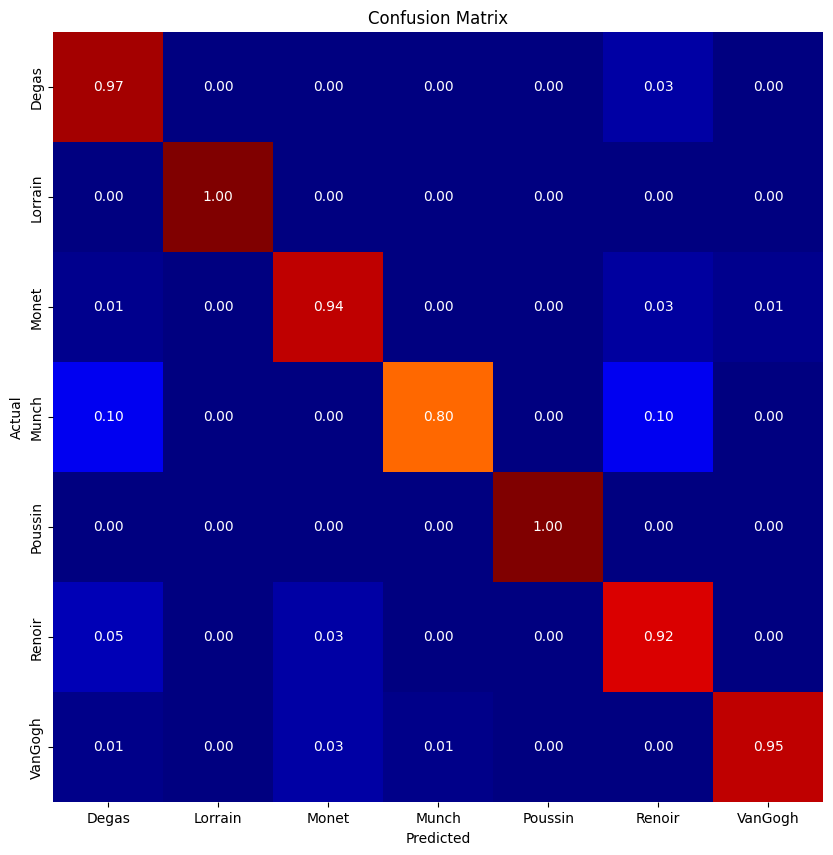

Classification Report:
              precision    recall  f1-score   support

       Degas       0.83      0.97      0.90        31
     Lorrain       1.00      1.00      1.00         8
       Monet       0.93      0.94      0.94        71
       Munch       0.89      0.80      0.84        10
     Poussin       1.00      1.00      1.00         5
      Renoir       0.94      0.92      0.93        63
     VanGogh       0.99      0.95      0.97        91

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



In [51]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = name.tolist()

def showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST):
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_TEST):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix = conf_matrix / row_sums 
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=name.tolist()))

showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST)


1/1 [==============================] - 0s 104ms/step


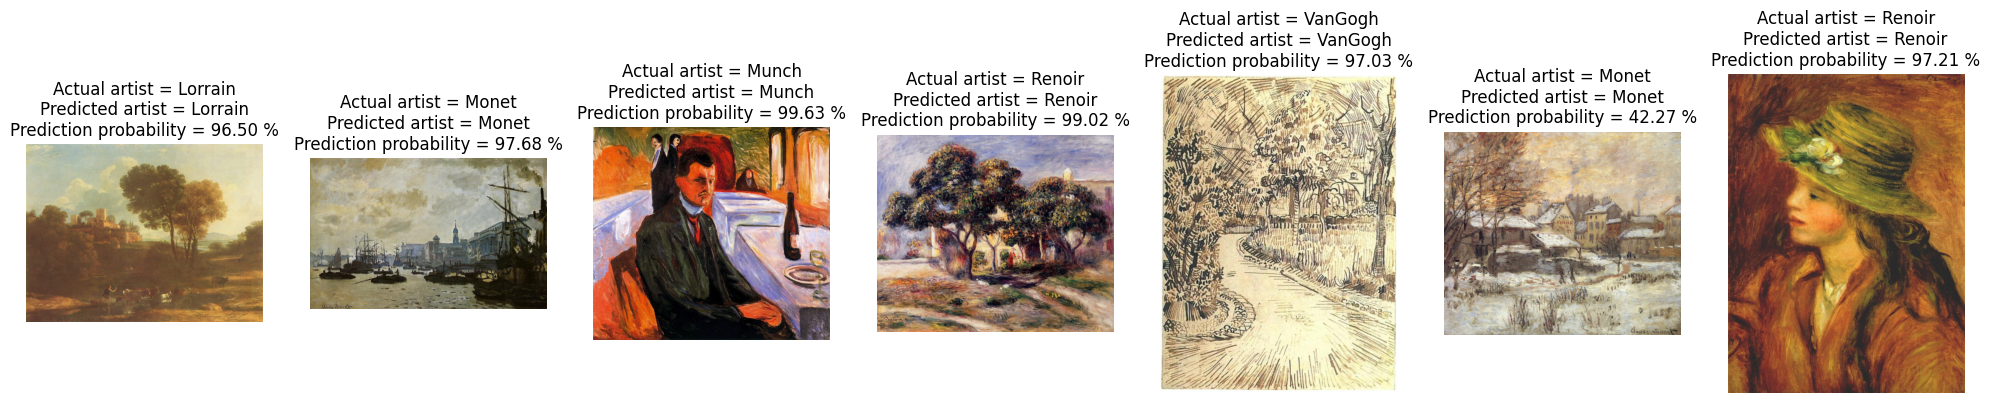

In [38]:
# Prediction
from keras.preprocessing import *

n = 7
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(name)
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)


    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))


    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

1/1 [==============================] - 0s 96ms/step


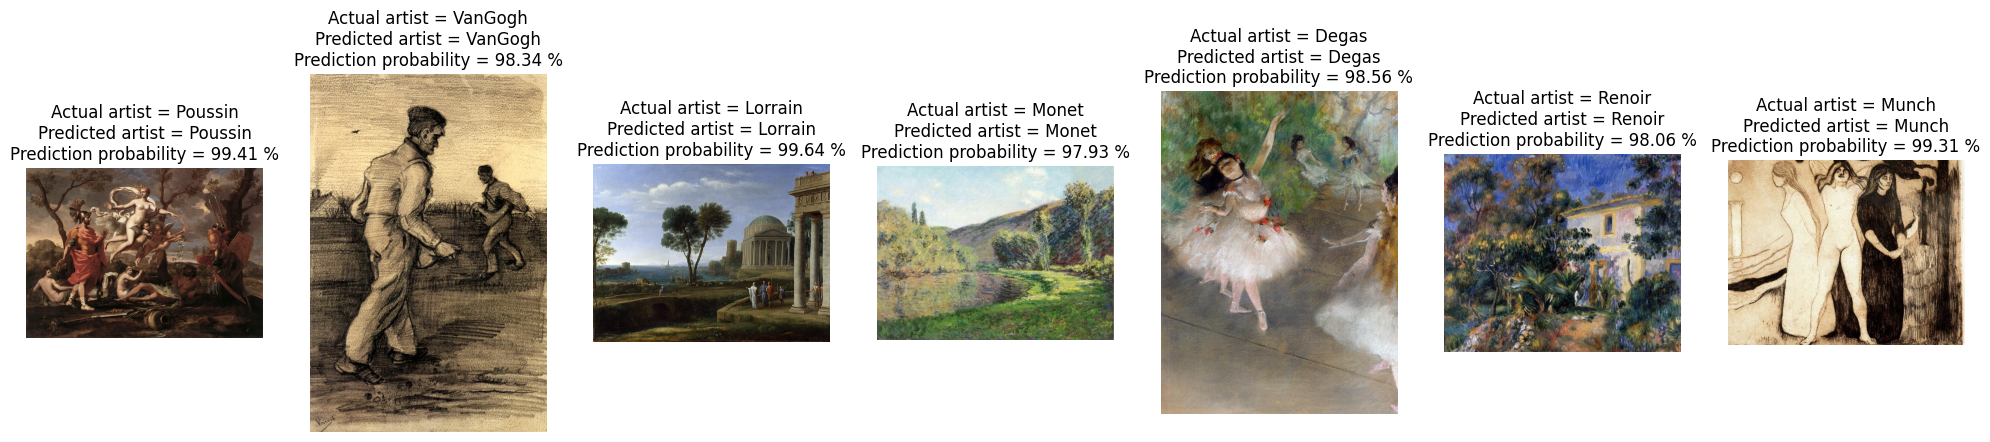

In [44]:
from keras.preprocessing import image
import random
import os
import matplotlib.pyplot as plt
import numpy as np

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))

unique_artists = set()

while len(unique_artists) < n:
    random_artist = random.choice(name)
    unique_artists.add(random_artist)

for i, random_artist in enumerate(unique_artists):
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0], train_input_shape[1]))

    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v, k) for k, v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
        .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '), prediction_probability * 100)

    # Display the image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()
